# FEniCS Introduction - Poisson Equation in 2D

This notebook starts a series of studies around the [FEM Book](https://github.com/hplgit/fem-book) by Hans Petter Langtangen and Kent-Andre Mardal. Here we intend to provide a more *Pythonic* way of programming FEniCS and also pack functions that are used in a recurrent fashion. That said, we start by import the specific functionalities from [`dolfin`](https://fenicsproject.org/olddocs/dolfin/latest/python/index.html) that will actually be used in the current project. In this tutorial we import functions by blocks, but as we advance these will progressivelly be grouped into a single import.

Since we have a [`fenix`](./fenix.py) module being developped in parallel to notebook, we enable auto-reload.

In [1]:
%load_ext autoreload
%autoreload 2

The first functionalities to import are those related to geometry, since we did not provide a real-world mesh here.

In [2]:
from dolfin import Point
from dolfin import RectangleMesh

With these elements on can declare points and discretize the 2D rectangular domain as follows:

In [3]:
nxy = 10
xy0 = Point(-1, -1)
xy1 = Point(1, 1)

mesh = RectangleMesh(xy0, xy1, nxy, nxy)

The problem we will be solving is expressed in weak form as:

$$
\int_{\Omega}\nabla{v}\cdotp\nabla{u}\,dx=\int_{\Omega}fv\,dx
$$

So that we need to define the `FunctionSpace` for the solution and from it define the `TrialFunction` $u$ and `TestFunction` $v$ required by the formulation. 

In [4]:
from dolfin import FunctionSpace
from dolfin import TrialFunction
from dolfin import TestFunction

First we declare the function space $V$ of polynomials of order 2 over which $u$ and $v$ are built.

In [5]:
V = FunctionSpace(mesh, "P", 2)
u = TrialFunction(V)
v = TestFunction(V)

This case will be solved with a simple vanishing essential boundary condition `DirichletBC` over all boundaries. Notice that this function must be specified over the same function space as the trial and test functions.

In [6]:
from dolfin import DirichletBC

Create a fixed boundary condition on borders.

In [7]:
bc = DirichletBC(V, 0, "on_boundary")

Now we can proceed with the *symbolic* declaration of the problem to be solved. In the integrands we have a pair of gradients `grad` associated to a dot product `dot` and integrated in space `dx`.

In [8]:
from dolfin import dot
from dolfin import grad
from dolfin import dx

Below we build the left-hand side integrand `a` and the right-hand side `L`. Notice that source `f` has been set to unity over the whole domain for simplicity here.

In [9]:
a = dot(grad(u), grad(v)) * dx
L = 1 * v * dx

Solving a problem is trivial with `dolfin`. We need a `Function` to hold the solution and the `solve` function which is responsible by managing the whole process and with applied boundary condition.

In [10]:
from dolfin import Function
from dolfin import solve

In [11]:
w = Function(V)
solve(a == L, w, bc)

Next we make use of a wrapper conceived in our module `fenix` to dump results to a VTK file.

In [12]:
from fenix import VtkFileWriter

In [13]:
pvd_file = "results/poisson_2d/data.pvd"
with VtkFileWriter(pvd_file) as fp:
    fp.write(w)

You can inspect files under this directory using system command as follows:

In [14]:
!ls -l results/poisson_2d/

total 12
-rw-r--r-- 1 root root  166 Jan 18 15:08 data.pvd
-rw-r--r-- 1 root root 8718 Jan 18 15:08 data000000.vtu


For post-processing to be possible from notebook, a good alternative is [`PyVista`](https://docs.pyvista.org/). If you are using a standard FEniCS Docker image, you might install the dependencies from terminal as:

```bash
pip3 install pyvista

apt install libgl1-mesa-glx xvfb
```

In [15]:
import pyvista as pv

pv.set_jupyter_backend("static")
pv.start_xvfb()

From the previous inspection we see the name of the `.vtu` file containing the results.

By inspecting point data we see scalar `f_7` holding our solution.

In [16]:
data = pv.read("results/poisson_2d/data000000.vtu")
data.point_data

pyvista DataSetAttributes
Association     : POINT
Active Scalars  : f_7
Active Vectors  : None
Active Texture  : None
Active Normals  : None
Contains arrays :
    f_7                     float64  (121,)               SCALARS

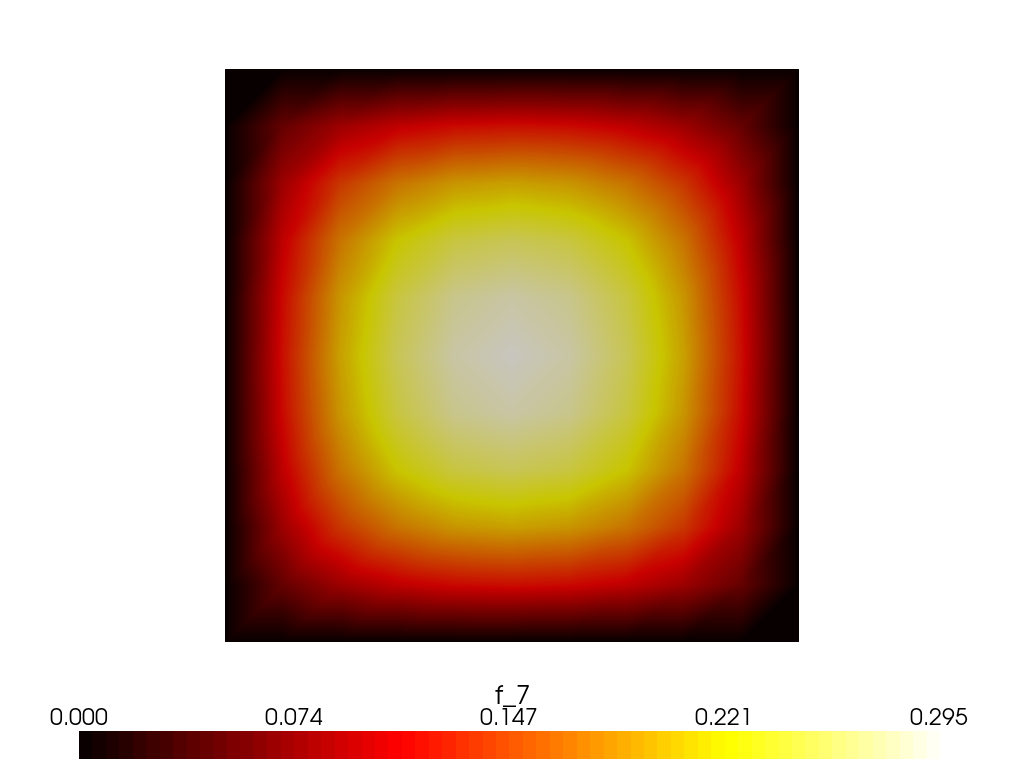

In [17]:
cpos = ((0.0, -0.1, 5.0),
        (0.0, -0.1, 0.0),
        (0.0, -0.0, 0.0))

opts = dict(
    cmap="hot",
    pbr=False,
    scalar_bar_args=dict(
        height=0.1,
        width=0.9, 
        position_x=0.05,
        position_y=0.01,
        color="k",
        fmt="%.3f"
    )
)
    
p = pv.Plotter(notebook=True)
p.set_background(color="w")
p.add_mesh(data, **opts, scalars="f_7")
p.show(cpos=cpos)

Hope you have enjoyed, see you next time!